## Machine Learning Abductive Loop

### Goals of this Procedure
1. Instantiate linear model.
2. Attempt to update parameters.
3. Recommend new experiments to run...

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mutual_info_score

from scipy.stats import invgamma, norm, multivariate_normal
from scipy.stats import zscore, sem, chi2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/output/grp-by-sessionId.csv', index_col=0)

In [3]:
data

,difi_pregame_mean,difi_pregame_var,difi_overlap_pregame_mean,difi_overlap_pregame_var,requestDiversity_mean,requestDiversity_var,participationRate_mean,participationRate_var,correctResponseRate_mean,correctResponseRate_var,letterRequestRate_mean,letterRequestRate_var,difi_linear_postgame_mean,difi_linear_postgame_var,difi_overlap_postgame_mean,difi_overlap_postgame_var,responseTimes_mean,responseTimes_var,pggContribution_mean,pggContribution_var
session.code,,,,,,,,,,,,,,,,,,,,
0j9gkpml,31.200000,5922.700000,40.000000,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.800000,5299.700000,43.600000,2548.800000,52.833333,829.366667,38.333333,806.666667
0v7aydut,39.875000,3014.383333,38.000000,1484.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.812500,2573.495833,49.437500,1630.129167,42.500000,526.133333,45.375000,1035.583333
20pmmmna,54.500000,5795.714286,53.750000,1749.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.625000,6289.125000,56.375000,2226.839286,62.375000,394.839286,60.625000,1274.553571
2413scgn,49.111111,2889.611111,42.666667,2055.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.111111,2019.611111,46.000000,1434.500000,41.555556,626.277778,76.111111,754.861111
2m9rd2cp,21.611111,2442.839869,20.611111,1042.251634,5.000000,0.923077,1.362349e+03,5.514733e+06,1.473142,2.902172,3.758416,19.533891,47.833333,987.424242,42.416667,1164.265152,52.214286,941.412088,57.357143,1535.170330
2mvuz23s,53.250000,4272.785714,46.500000,2123.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.500000,4606.857143,57.000000,2196.285714,43.750000,398.785714,50.625000,1260.267857
31f1vzlc,71.230769,3417.025641,57.692308,2365.230769,4.500000,3.388889,2.242548e+03,8.407011e+06,2.261036,6.375214,6.285599,97.460765,78.800000,3261.288889,68.700000,1577.344444,62.363636,855.454545,59.090909,749.090909
3k2emuiz,33.444444,2999.027778,36.222222,1398.694444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.666667,5089.000000,42.888889,1904.861111,38.555556,191.277778,39.555556,1705.527778
3nmquptg,63.600000,3364.300000,52.800000,2125.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.800000,1210.700000,73.800000,974.200000,46.400000,704.800000,62.000000,1320.000000


In [4]:
test = data[['difi_pregame_mean', 'difi_pregame_var', 'difi_overlap_pregame_mean', 'difi_overlap_pregame_var','pggContribution_mean']].dropna()
x = test[['difi_pregame_mean', 'difi_pregame_var', 'difi_overlap_pregame_mean', 'difi_overlap_pregame_var']].as_matrix()
x = zscore(x, axis = 0)
x = np.c_[x,np.ones([len(x),1])]
y = test[['pggContribution_mean']].as_matrix()
print x.shape, y.shape

(59, 5) (59, 1)


In [5]:
n = float(len(y)) ## import from data
p = float(x.shape[1])   ## import from data

inv = np.linalg.inv(np.dot(x.T,x)) 
P = np.dot(np.dot(x,inv),x.T)

a = (n-p)/2.
s2 = (1./(n-p))*np.dot(np.dot(y.T,np.eye(P.shape[0])-P), y)
scale = ((n-p) * s2 / 2.)

print s2
sigma2hat = invgamma.rvs(a,scale=scale,size=10000)
Bhat = np.dot(inv,np.dot(x.T,y))
print Bhat

[[ 287.1242853]]
[[ 16.05704162]
 [ 10.95261   ]
 [-14.2777663 ]
 [ -7.29335421]
 [ 52.25230846]]


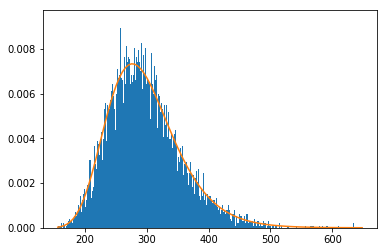

In [6]:
_ = plt.hist(sigma2hat,500,normed=True)
phi = np.linspace(sigma2hat.min(),sigma2hat.max(),100)
_ = plt.plot(phi,invgamma.pdf(phi,a,scale=scale).T)

In [7]:
bsamples = []

for sigma2 in sigma2hat:
    bhat = multivariate_normal.rvs(mean = np.ravel(Bhat), cov = np.dot(inv,sigma2))
    bsamples.append(bhat)
    
bsamples = np.array(bsamples)

## $P(\beta,y)$ - Parameter Estimation

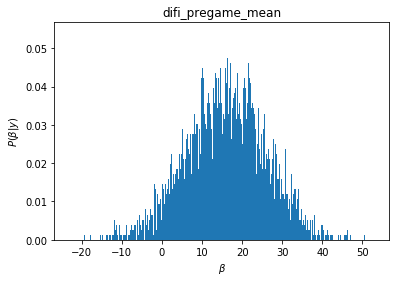

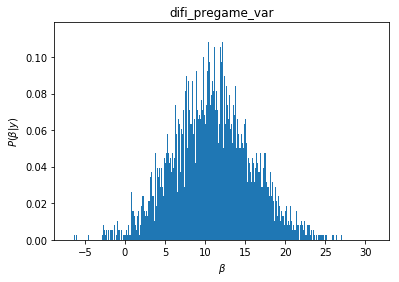

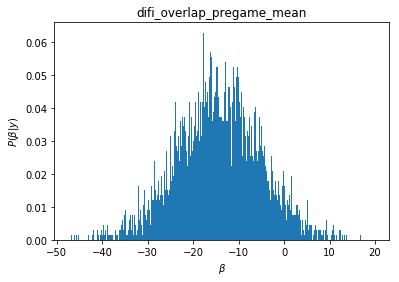

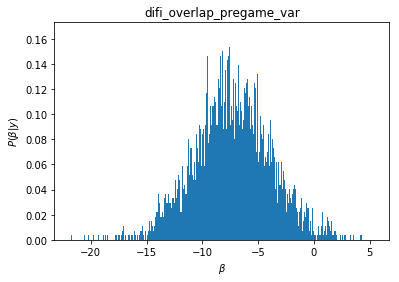

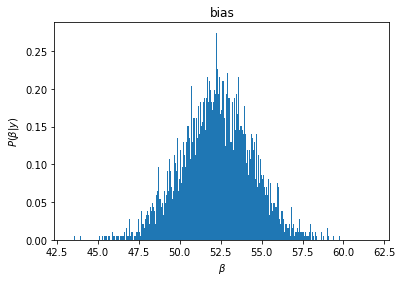

In [8]:
titles = list(test.columns[:-1])
titles.append("bias")
for bs,title in zip(bsamples.T,titles):
    plt.figure()
    _ = plt.hist(bs, 1000, normed = True)
    plt.title(title)
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$P(\beta|y)$')
    plt.savefig('./img/{}.png'.format(title))
    


# $P(\hat y | y)$ - Predict Outputs

In [9]:
Y_hat = []
for b,s in zip(bsamples,sigma2hat):
    y_hat = norm.rvs(np.dot(x,b),s)
    Y_hat.append(y_hat)
Y_hat = np.array(Y_hat)
print Y_hat.shape

(10000, 59)


AttributeError: Unknown property axis

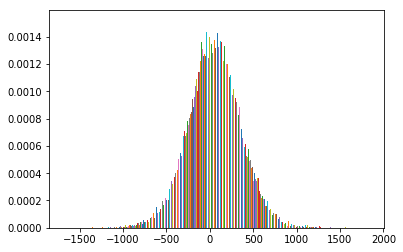

In [15]:
_ = plt.hist(Y_hat,100, normed = True, axis=0)

plt.title(r'$P(\tilde y | y)$')
plt.xlabel('PGG Contribution (% earnings)', fontsize = 16)
plt.savefig('./img/yout.png')

# Validation Section
# $\tau$ - Threshold

In [11]:
tau = 0.5

# $P(\tilde e | h_0)$ - Probability of $h_0$

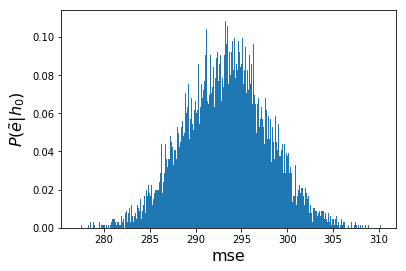

In [20]:
# Compute Output
y_bar = y.mean()
#print y_bar

y_sem = sem(np.ravel(y))
#print y_sem

y_hat_dummy = norm.rvs(loc = y_bar, scale = y_sem, size = 10000)
#_ = plt.hist(y_hat_dummy, 300, normed = True)

# Convert to Evidence for Hypothesis
y_test = y[0]

err_samples = multivariate_normal.rvs(mean = np.ravel(y_bar - y), cov=np.eye(y.shape[0]), size = 10000)
err_bar = (err_samples**2).mean(axis = 1)
dof = len(err_samples)

plt.figure()
_ = plt.hist(err_bar, 500, normed = True)
_ = plt.xlabel(r'mse', fontsize = 16)
_ = plt.ylabel(r'$P(\tilde e|h_0)$', fontsize = 16)

loc, scale =  chi2.fit_loc_scale(err_bar, dof)
xaxis = np.linspace(250,320,100)
#plt.plot(xaxis, chi2.pdf(xaxis, dof, loc=loc, scale=scale))

plt.savefig('./img/errorH0.png')

h0 = chi2(dof,loc=loc, scale=scale)

# $P(\tilde e|h_i)$ - Predict/Abduce Over Hypotheses
» Improve this method...

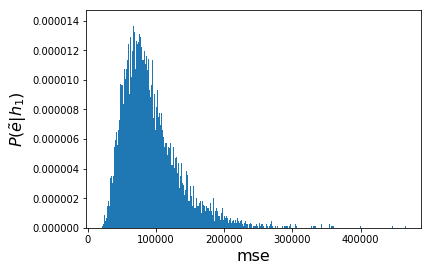

In [19]:
err_samples = Y_hat.T - y
err_bar =  (err_samples**2).mean(axis = 0)
dof = len(err_samples)

plt.figure()
_ = plt.hist(err_bar, 500, normed = True)
_ = plt.xlabel(r'mse', fontsize = 16)
_ = plt.ylabel(r'$P(\tilde e|h_1)$', fontsize = 16)
plt.savefig('./img/errorH1.png')

loc, scale =  chi2.fit_loc_scale(err_bar, 59)
xaxis = np.linspace(0,300000,100)
#plt.plot(xaxis, chi2.pdf(xaxis, dof, loc=loc, scale=scale))

h1 = chi2(dof, loc=loc, scale=scale)

# $P(h|\tilde e)$ - Probability Distribution

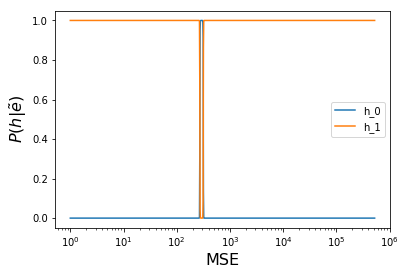

In [21]:
xaxis = np.logspace(0,19,1000,base=2)
ph0 = h0.pdf(xaxis)
ph1 = h1.pdf(xaxis)
#pnull = 1 - (ph0 + ph1)
den = h0.pdf(xaxis) + h1.pdf(xaxis)# + pnull

ph0 = ph0/den #* h0.pdf(xaxis)
ph1 = ph1/den #* h1.pdf(xaxis)

#plt.plot(xaxis,pnull)
plt.plot(xaxis,ph0, label="h_0")
plt.plot(xaxis,ph1, label="h_1")
plt.semilogx(basex = 10)

plt.xlabel('MSE', fontsize = 16)
_ = plt.ylabel(r'$P(h|\tilde e)$', fontsize = 16)
plt.legend()

# $P(h|H)$ - Marginal Probability of Hypotheses

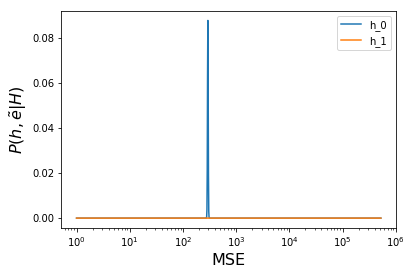

In [22]:
plt.plot(xaxis,ph0 * den, label="h_0")
plt.plot(xaxis,ph1 * den, label="h_1")
plt.semilogx(basex = 10)

plt.xlabel('MSE', fontsize = 16)
_ = plt.ylabel(r'$P(h,\tilde e|H)$', fontsize = 16)
plt.legend()

plt.savefig('./img/marginal_H.png')

(array([ 428.,    0.,    0.,    0.,    1.,  119.,   21.,   21.,   29.,  381.]),
 array([ 0.        ,  0.09939807,  0.19879614,  0.29819421,  0.39759227,
         0.49699034,  0.59638841,  0.69578648,  0.79518455,  0.89458262,
         0.99398068]),
 <a list of 10 Patch objects>)

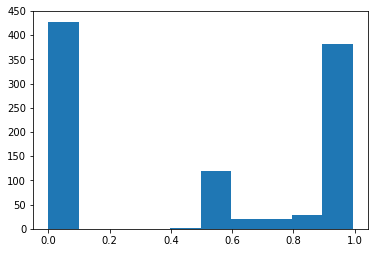

In [138]:
plt.hist(ph0)

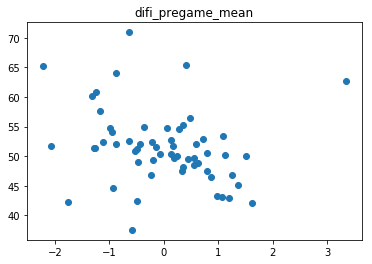

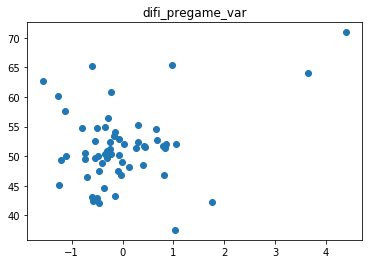

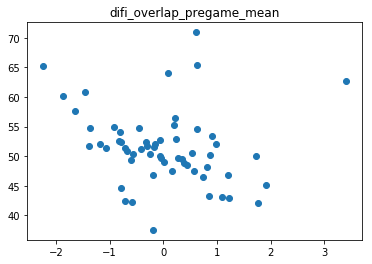

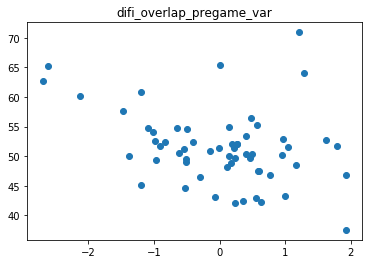

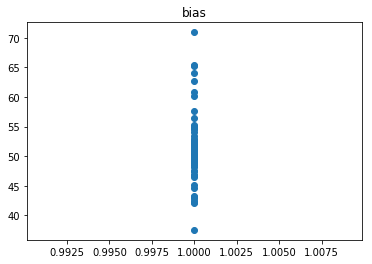

In [11]:
y_bar = Y_hat.mean(axis=0)
for x_bar, title in zip(x.T,titles):
    plt.figure()
    plt.scatter(x_bar,y_bar)
    plt.title(title)

In [13]:
test.corr()

,difi_pregame_mean,difi_pregame_var,difi_overlap_pregame_mean,difi_overlap_pregame_var,pggContribution_mean
difi_pregame_mean,1.000000,-0.320435,0.919786,0.120750,-0.085699
difi_pregame_var,-0.320435,1.000000,-0.042081,0.555634,0.137739
difi_overlap_pregame_mean,0.919786,-0.042081,1.000000,0.159531,-0.066253
difi_overlap_pregame_var,0.120750,0.555634,0.159531,1.000000,-0.090425
pggContribution_mean,-0.085699,0.137739,-0.066253,-0.090425,1.000000


## Ideas for moving forward:

### What we've done:

1. Exploratory Analysis

1. Two treatments:

    a. Group Size (non-structural change)
    
    b. Team-based Activity (structural change)
    
    c. Should there be another?
    
        i. indicators from data
        
        ii. indicators from literature

### Two Options:

1. Conduct more of the same experiments to refine parameters.

2. Try other treatments.

### How to get there:

1. Break results into sections - can N = 5, 10 predict N = 20? (confirmation (validation) test of current parameters)

    a. Can we quantify the change? Can we see if there is any probability of change - worth continuing the experiments?
    
    b. Would give an indication of whether or not the current treatment will be effective given other parameters.
    
    c. Assume that you should test the entire parameter suite, but perhaps one parameter may be more worthwhile than the other.
    
    d. This uses parameters as a prior.
    
    e. What kind of results would we need in order to satisfy the threshold requirement? Pick a sigma and figure out what is needed to test...
    
2. Given what we know, is there another parameter that appears, perhaps, to reduce the output variance (spread to variance ratio).
    
    a. From literature, we have not tested connectivity - what should we expect / how much (business as usual)?
    
    b. What is the maximum significance we can find with our data? Go search for a possibly spurious/over fit model and test.
    
    c. What parameter ranges have we yet to try?
        
        i. difficult for linear model (how to quantify / test)
        
3. When to disregard the model?

    a. Exhaust parameter space - no evidence of meeting threshold. 
    b. Resources exhausted.
    
### System Constraints:

1. Topic of investigation / boundary of what we're interested in studying.

2. Resources Available

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9402e61950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9402cd84d0>]], dtype=object)

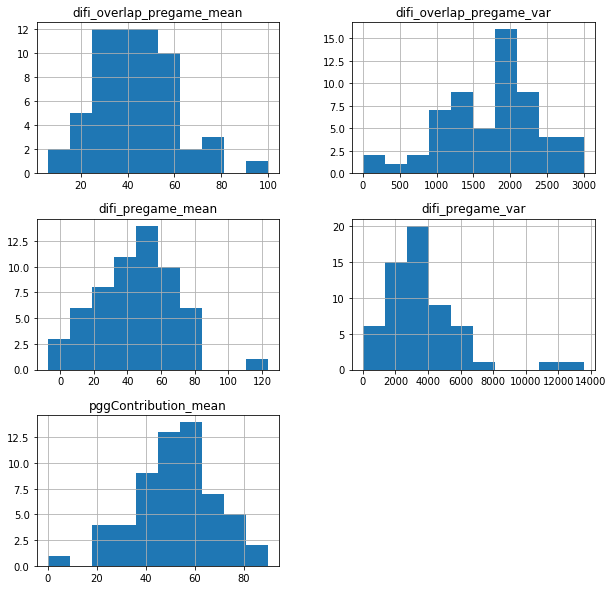

In [161]:
test.hist(figsize = (10,10))

## Mutual Information Matrix

0.438523389326
2.22044604925e-16
1.97225989622


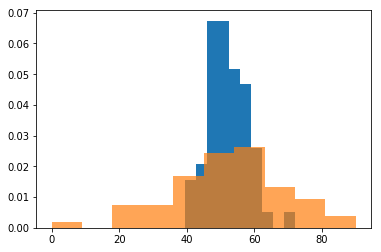

In [183]:
yhatmean = Y_hat.mean(axis=0)
Cxy = np.histogram2d(yhatmean,np.ravel(y))[0]

print mutual_info_score(None,None,contingency=Cxy)

yhatdummy = y_hat_dummy.mean() * np.ones((1,59))
Cxy = np.histogram2d(np.ravel(yhatdummy),np.ravel(y))[0]

print mutual_info_score(None,None,contingency=Cxy)


Cxy = np.histogram2d(np.ravel(y),np.ravel(y))[0]

print mutual_info_score(None,None,contingency=Cxy)

_ = plt.hist(yhatmean, normed = True)
_ = plt.hist(y, normed= True, alpha = .7)

In [284]:
samp = 200
existing = zip(yhatmean,np.ravel(y))
new = np.random.randint(0,100,size = samp)

MI_spread = []
Max_MI = []

for i in range(1,samp):
    app = zip(new[0:i],new[0:i])
    existing.extend(app)
    
    y1,y2 = zip(*existing)
    y1 = np.array(y1)
    y2 = np.array(y2)
    Cxy = np.histogram2d(y1,y2, bins = 12)[0]
    Cxy2 = np.histogram2d(y2,y2, bins = 12)[0]

    MI_spread.append(mutual_info_score(None,None,contingency=Cxy))
    Max_MI.append(mutual_info_score(None,None,contingency=Cxy2))

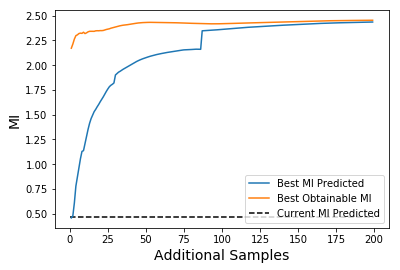

In [289]:
plt.plot(range(1,samp),MI_spread, label = 'Best MI Predicted')
plt.plot(range(1,samp),Max_MI, label = 'Best Obtainable MI')
plt.hlines(0.47, 0, 200, linestyle = '--', label = 'Current MI Predicted')

plt.xlabel(r'Additional Samples', fontsize = 14)
plt.ylabel(r'MI', fontsize = 14)
plt.legend()

## Next Steps - Mutual Information; Other Data

In [23]:
n_features = len(data.columns)

MI = np.empty(shape = (n_features,n_features))
for i in range(n_features):
    for j in range(n_features):
        Cxy = np.histogram2d(data.iloc[:,i].replace(np.nan,0),data.iloc[:,j].replace(np.nan,0))[0]
        MI[i,j] = mutual_info_score(None,None,contingency=Cxy)

In [24]:
MI = pd.DataFrame(MI,columns = data.columns, index = data.columns)

In [25]:
MI.iloc[0:12,:]['pggContribution_mean'].sort_values(ascending=False)

difi_overlap_pregame_var     0.517940
difi_overlap_pregame_mean    0.439017
difi_pregame_mean            0.438161
requestDiversity_var         0.433535
requestDiversity_mean        0.402456
difi_pregame_var             0.379642
letterRequestRate_mean       0.332394
correctResponseRate_mean     0.313915
letterRequestRate_var        0.281218
correctResponseRate_var      0.175206
participationRate_var        0.047277
participationRate_mean       0.047277
Name: pggContribution_mean, dtype: float64